## Filtering CPR Generation Policy responses

The aim of this notebook is to create a subset of the aggregated policy alignment human annotations using the other axes, namely:
- should-have-responded
- length of the retrieved results

In [104]:
import sys
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

sys.path.append(Path(".").absolute().parent.parent.as_posix())

from src.evaluation.evaluator import Score, EndToEndGeneration
from src.evaluation.system_response import SystemResponse

In [16]:
cpr_generation_policy_path = Path("../../data/eval/cpr_generation_policy_human_annotation_scores.jsonl")
should_have_responded_path = Path("../../data/eval/should_have_responded_human_annotation_scores_majority.jsonl")

output_path = Path("../../data/eval/cpr_generation_policy_filtered_by_should_have_responded.jsonl")

In [82]:
cpr_generation_policy_scores = [json.loads(line) for line in cpr_generation_policy_path.read_text().strip().split("\n")]
should_have_responded_scores = [json.loads(line) for line in should_have_responded_path.read_text().strip().split("\n")]
print(len(cpr_generation_policy_scores), len(should_have_responded_scores))

994 1001


In [100]:
policy_violation_ids = set(score["gen_uuid"] for score in cpr_generation_policy_scores if score["score"] == 0.0)

In [14]:
should_not_have_responded_ids = [score["gen_uuid"] for score in should_have_responded_scores if score["score"] == 0.0]
len(should_not_have_responded_ids)

269

In [15]:
filtered_cpr_generation_policy_scores = [score for score in cpr_generation_policy_scores if score["gen_uuid"] not in should_not_have_responded_ids]
len(filtered_cpr_generation_policy_scores)

758

In [17]:
with open(output_path, "w") as f:
    for score in filtered_cpr_generation_policy_scores:
        f.write(json.dumps(score) + "\n")

In [20]:
# create the relevant generations file

ids = [score["gen_uuid"] for score in filtered_cpr_generation_policy_scores]


df = pd.read_json("../../data/final_2_all.jsonl", lines=True)
df["uuid"] = df["generation"].apply(lambda x: EndToEndGeneration.model_validate(x).uuid)

filtered_by_should_not_have_responded = df[df["uuid"].isin(ids)]
filtered_by_should_not_have_responded.drop(columns=["uuid"], inplace=True)
print(filtered_by_should_not_have_responded.shape)

(772, 9)


/var/folders/c1/skfn6y1s1432yhzx3z_2zrph0000gn/T/ipykernel_76440/3483973100.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset.drop(columns=["uuid"], inplace=True)


In [22]:
filtered_by_should_not_have_responded.to_json("../../data/eval/generations/cpr_generation_policy_filtered_generations.jsonl", orient="records", lines=True)

## Retrieved passage as indicator

In the following, looking at the retrieved passage length as an indicator to whether the system could have responded.


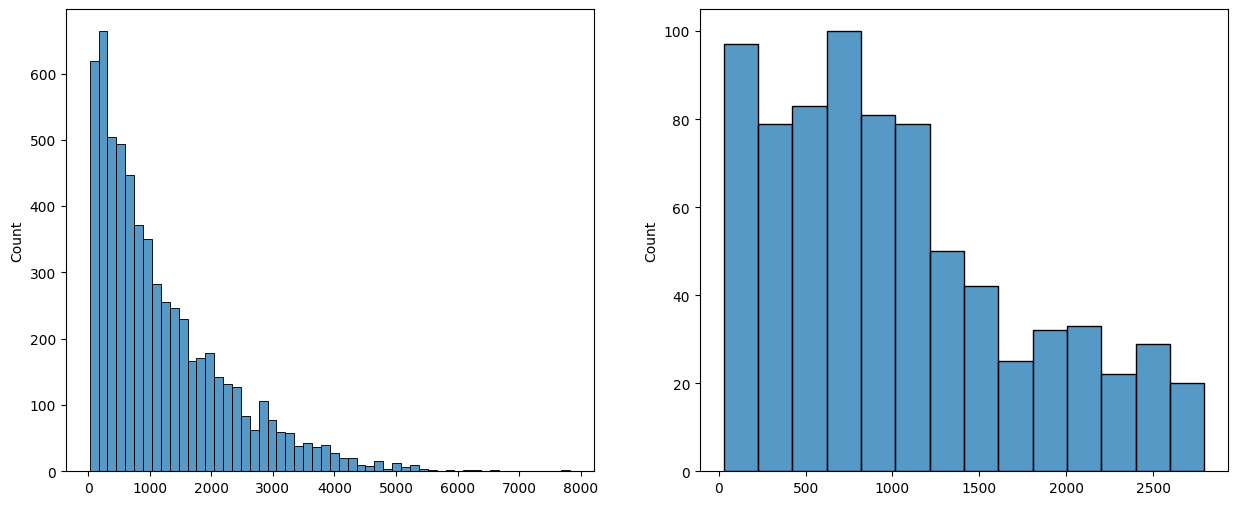

In [55]:
def get_length(x):
    e2e_gen = EndToEndGeneration.model_validate(x["generation"])
    if e2e_gen.rag_response is not None:
        return len(e2e_gen.rag_response.retrieved_passages_as_string())
    return None

lengths_df = df.apply(lambda x: get_length(x), axis=1)
lengths_filtered = filtered_by_should_not_have_responded.apply(lambda x: get_length(x), axis=1)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(lengths_df.dropna(), ax=ax[0])
sns.histplot(lengths_filtered.dropna(), ax=ax[1])
plt.show()

The distribution seems different, which suggests that the should-have-responded filter removed a bunch of the very short retrievals.

In [56]:
df["retrieve_passage_length"] = df.apply(lambda x: get_length(x), axis=1)

short_retrieval = df[(~df["retrieve_passage_length"].isna()) & (df["retrieve_passage_length"] < 300)]

In [59]:
def print_retrieval(x):
    print("="*100)
    e2e_gen = EndToEndGeneration.model_validate(x["generation"])
    if e2e_gen.rag_response is not None:
        print(e2e_gen.rag_response.retrieved_passages_as_string())

In [61]:
_ = short_retrieval.sample(10).apply(lambda x: print_retrieval(x), axis=1)

[1]: This policy examines the core concepts of Sustainable Development upon which the national definition was built and in light of which specific policy statements are made. The main objectives of this policy are:
[2]: 4. Policy Objectives & Goals
[3]: 4. POLICY OBJECTIVES & GOALS
[1]: 5.1.4. must be ensuring public participation.
[2]: CHAPTER TWO. DEVELOPMENT POLICY DOCUMENTS
[3]: Article. 6. Types of development policy documents
[1]: Renewable Fuels Regulations
[2]: Renewable Fuels Regulations
[3]: Renewable Fuels Regulations
[1]: opportunities for green growth implementation in Jordan;
[2]: 2. Assessing Green Growth in Jordan's Agriculture Sector
[3]: 2. Assessing Green Growth in Jordan's Agriculture Sector 07
[1]: Managing the transition to low-emissions power
[2]: Chapter 2: Managing the transition to low-emissions power
[3]: Chapter 2 | Managing the transition to low-emissions power
[1]: Functions, Duties and Powers of the National Disaster Controller
[2]: 11. Functions, Duties 

All of the above are of low quality, so the limit of 300 feels like a good place to start as a heuristic to say, the question is unlikely to be answerable based on this much information.<br><br>
Quickly checking, how does this correlate with the "should have responded" answers.

In [95]:
# getting only those generations that were in the original CPR-generation-policy dataset
original_ids = [score["gen_uuid"] for score in cpr_generation_policy_scores]
original_dataset = df[df["uuid"].isin(original_ids)]
original_dataset.drop_duplicates(subset=["uuid"], inplace=True)
print(original_dataset.shape[0])

994


/var/folders/c1/skfn6y1s1432yhzx3z_2zrph0000gn/T/ipykernel_76440/3595548815.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_dataset.drop_duplicates(subset=["uuid"], inplace=True)


In [96]:
# identifying those generations that are short (less than 300 characters)
original_dataset["retrieve_passage_length"] = original_dataset.apply(lambda x: get_length(x), axis=1)
original_short_retrieval = original_dataset[(~original_dataset["retrieve_passage_length"].isna()) & (original_dataset["retrieve_passage_length"] < 300)]
original_dataset.shape[0], original_short_retrieval.shape[0]

/var/folders/c1/skfn6y1s1432yhzx3z_2zrph0000gn/T/ipykernel_76440/2686048241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_dataset["retrieve_passage_length"] = original_dataset.apply(lambda x: get_length(x), axis=1)


(994, 228)

In [97]:
print(f"The intersection of short retrieved passages and should-not-have-responded: {len(set(original_short_retrieval['uuid'].tolist()).intersection(set(should_not_have_responded_ids)))}")

The intersection of short retrieved passages and should-not-have-responded: 93


In [103]:
print(f"All should-not-have-responded: {len(should_not_have_responded_ids)}, out of which policy violation ids: {len(policy_violation_ids.intersection(should_not_have_responded_ids))}")
print(f"All short retrieved passages: {original_short_retrieval.shape[0]}, out of which policy violation ids: {len(policy_violation_ids.intersection(set(original_short_retrieval['uuid'].tolist())))}")

All should-not-have-responded: 269, out of which policy violation ids: 46
All short retrieved passages: 228, out of which policy violation ids: 35


In [93]:
filtered_by_retrieval_length = original_dataset[~original_dataset["uuid"].isin(original_short_retrieval["uuid"].tolist())]
assert filtered_by_retrieval_length.shape[0] == 994 - 228

In [94]:
filtered_by_retrieval_length.to_json(
    "../../data/eval/generations/cpr_generation_policy_filtered_by_retrieval_length.jsonl",
    orient="records",
    lines=True
)

## Filtering by no response cases

In [105]:
system_response_evaluator = SystemResponse()

In [109]:
original_dataset["system_response"] = original_dataset["generation"].apply(lambda x: system_response_evaluator.evaluate(EndToEndGeneration.model_validate(x)).score)

/var/folders/c1/skfn6y1s1432yhzx3z_2zrph0000gn/T/ipykernel_76440/108468017.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_dataset["system_response"] = original_dataset["generation"].apply(lambda x: system_response_evaluator.evaluate(EndToEndGeneration.model_validate(x)).score)


In [114]:
filter_dataset_by_system_responds = original_dataset[original_dataset["system_response"] == 1.0]
filter_dataset_by_system_responds.shape[0]

610

In [115]:
filter_dataset_by_system_responds.to_json(
    "../../data/eval/generations/cpr_generation_policy_filtered_by_system_responds.jsonl",
    orient="records",
    lines=True
)

## No response & short context

In [123]:
original_short_retrieval.shape[0], filter_dataset_by_system_responds.shape[0]

(228, 610)

In [124]:
len(set(original_short_retrieval["uuid"].tolist()).intersection(set(filter_dataset_by_system_responds["uuid"].tolist())))

98

In [125]:
filtered_by_response_and_retrieval_length = filter_dataset_by_system_responds[
    ~filter_dataset_by_system_responds["uuid"].isin(original_short_retrieval["uuid"].tolist())
]

assert filtered_by_response_and_retrieval_length.shape[0] == 610 - 98

In [126]:
filtered_by_response_and_retrieval_length.to_json(
    "../../data/eval/generations/cpr_generation_policy_filtered_by_response_and_retrieval_length.jsonl",
    orient="records",
    lines=True
)

In [129]:
remaining_scores = [score for score in cpr_generation_policy_scores if score["gen_uuid"] in filtered_by_response_and_retrieval_length["uuid"].tolist()]

print(
    f"Remaining items that break the policy: {len([s for s in remaining_scores if s['score'] == 0.0])} "\
    f"and those that follow it: {len([s for s in remaining_scores if s['score'] == 1.0])}"
)

Remaining items that break the policy: 51 and those that follow it: 461
